<a href="https://colab.research.google.com/github/andrerubeis/andrerubeis/blob/main/probability_windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle
import noisereduce as nr
import tqdm

In [4]:
import torch
colab = True

if colab == True:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!nvidia-smi

Thu Jan 19 21:47:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    30W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


## 1. Loading Dataset

In [7]:
colab = True

if colab == True:
  path= r'/content/development.csv'
else:
  path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'

df_development = pd.read_csv(path)
df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


In [8]:
#Evlauate balancement of dataset
df_development.action.value_counts(), df_development.object.value_counts()

(increase           3823
 decrease           3575
 change language    1113
 activate            791
 deactivate          552
 Name: action, dtype: int64, volume    5000
 heat      2398
 none      1113
 music      791
 lights     552
 Name: object, dtype: int64)

### Evaluate all the existing combinations in the dataset

In [9]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [10]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [11]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [12]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [13]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### Creating new training dataset
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=increase and object=heat has label 1)

In [14]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']=1
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']=2

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']=3
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']=4

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']=5

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']=6
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']=7

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,6
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,7
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,3
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7


In [15]:
df_development.iloc[9845]

Id                                                                                    9845
path                                     dsl_data/audio/speakers/Pz327QrLaGuxW8Do/20e47...
speakerId                                                                 Pz327QrLaGuxW8Do
action                                                                     change language
object                                                                                none
Self-reported fluency level                                                         native
First Language spoken                                              English (United States)
Current language used for work/school                              English (United States)
gender                                                                              female
ageRange                                                                             22-40
labels                                                                                   5

In [16]:
if colab == True:
  path_working_directory= r'/content/drive/MyDrive/'
else:
  path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_development['path']

Load pickle file.

In [17]:
name_file = r'/df.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df = pickle.load(f)
df_pd = pd.DataFrame({'audio':df[1], 'gender': df_development.gender, 'ageRange': df_development.ageRange, 'label':df[3]})
#df_pd[9840:9845] ETICHETTATO COME FEMALE MA SECONDO ME E MALE

In [18]:
# Test
# df_female = df_development[df_development['gender']=='female']
# df_female

In [19]:
# Test
# df_development.gender.value_counts()

In [20]:
# Test
# index = 9845
# path_audio = df_development.path[index]
# path_working_directory+'/'+path_audio
# ipd.Audio(path_working_directory+'/'+path_audio)

 if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
 
n_samples /sr = seconds
n_samples = seconds*sr


In [21]:
# 10e-3*sr

In [22]:
# 2048/sr

See distribution of audio length

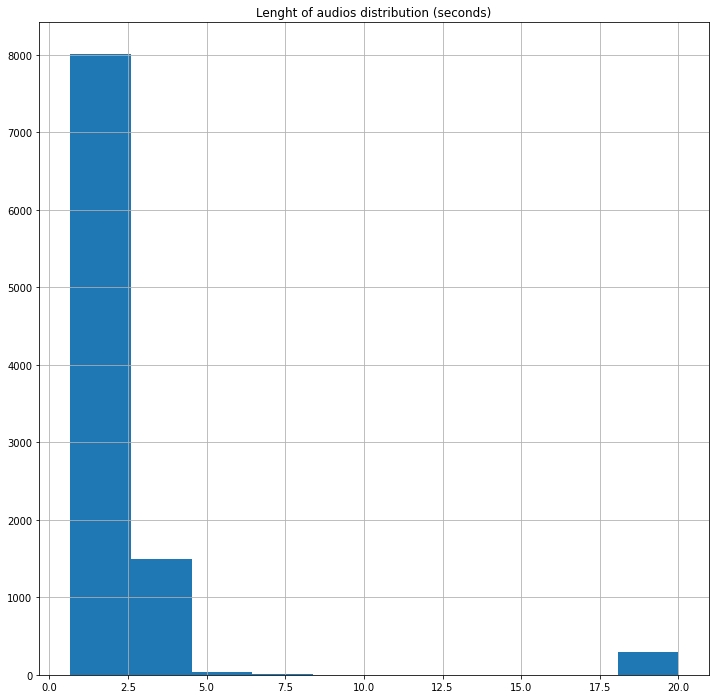

In [23]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
        indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
plt.title("Lenght of audios distribution (seconds)")
length_audios_seconds.hist()
#print(length_audios_seconds)


In [25]:
# See info of audios within specific range
#df_pd.iloc[indexes]

In [26]:
# index = 7123
# path_audio = df_development.path[index]
# path_working_directory+'/'+path_audio
# ipd.Audio(df_pd['audio'][7123], rate=22050)

### 2. Pre-Processing

According to several papers focused on audio classification, VDA is among one of the most preprocessing techinque adopted which aims to trim all the silence parts away from audio files.

To apply it, we will use _trim_ and _split_ librosa functions.

- _trim_: cut silence frames at the beginning and in the end of an audio file.
- _split_: saves the indexes (start, stop) of each non-silent frame in the audio file.

#### Trim

In [27]:
trim_audios = []
for i, audio in enumerate(df_pd.audio):
    audio_trim = librosa.effects.trim(audio, top_db=20)[0]
    trim_audios.append(audio_trim)
    
df_pd['audio_trim'] = trim_audios    
df_pd

,audio,gender,ageRange,label,audio_trim
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,5,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,6,"[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,7,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...
9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,3,"[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,7,"[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,7,"[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,7,"[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


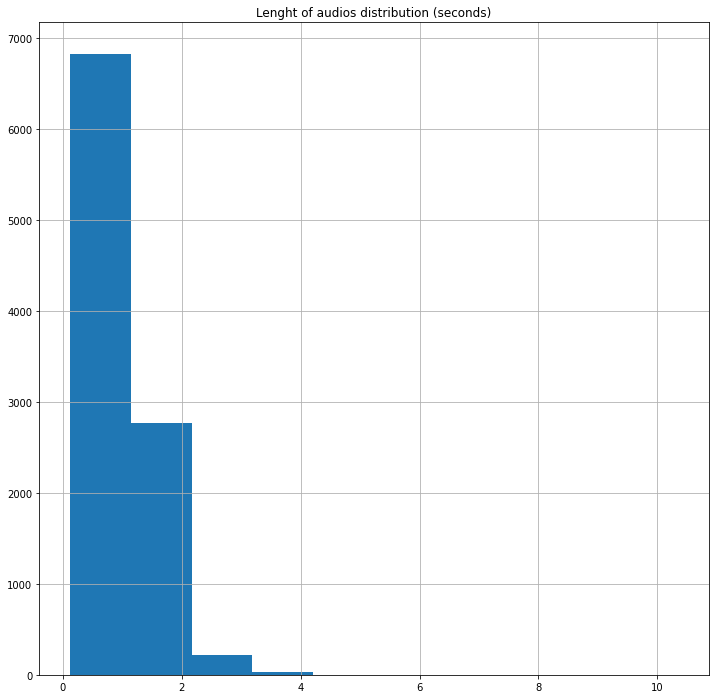

In [28]:
length_audios_trim = []
length_audios_seconds_trim = []
indexes = []
i = 0

for item in df_pd.audio_trim:
    length_audios_trim.append(len(item))
    length_audios_seconds_trim.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    if len(item)/sr  > 4: # se 2.64 prestazioni minori
        indexes.append(i)
    i = i+1
        

length_audios_trim=pd.Series(length_audios_trim)
length_audios_seconds_trim = pd.Series(length_audios_seconds_trim)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
plt.title("Lenght of audios distribution (seconds)")
length_audios_seconds_trim.hist()
#print(length_audios_seconds)


In [29]:
len(indexes)

6

In [30]:
df_pd=df_pd.drop(indexes).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,audio,gender,ageRange,label,audio_trim
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,5,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,6,"[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,7,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...
9843,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,3,"[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9844,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,7,"[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9845,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,7,"[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9846,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,7,"[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


#### Denoising

In [31]:
# audio = df_pd.audio[7]
# clean_audio=nr.reduce_noise(y=audio, sr=sr, n_std_thresh_stationary=1.5, stationary=True)

In [32]:
# ipd.Audio(audio, rate=22050)

In [33]:
# ipd.Audio(clean_audio, rate=22050)

In [34]:
# audios_cleaned = []

# for audio in df_pd.audio_trim:
    
#     audio_clean = nr.reduce_noise(y=audio, sr=sr, n_std_thresh_stationary=1.5, stationary=True)
#     audios_cleaned.append(audio_clean)
# #new_audio_reconstructed = np.hstack(audio_reconstructed)
# #s1 = df_pd['audio'][idx][non_silence_parts[1][0]:non_silence_parts[1][-1]]
# # s2 = df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[1][0]:librosa.effects.split(df_pd['audio'][3799])[1][-1]]

# #ipd.Audio(new_audio_reconstructed, rate=22050)

In [35]:
# df_pd['audio_cleaned'] = audios_cleaned    
# df_pd

#### Split

In [36]:
# idx = 8136
# s =df_pd.audio[idx]
# ipd.Audio(df_pd['audio_cleaned'][idx], rate=22050)

In [37]:
audios_reconstructed = []

for audio in df_pd.audio_trim:
    
    non_silence_parts = librosa.effects.split(audio, top_db=20)
    audio_reconstructed_parts = [] #save the non silent parts in a list that then will be merged together to obtain the reconstructed file
    
    for part in non_silence_parts:
        audio_reconstructed_parts.append(audio[part[0]:part[-1]])

    audio_reconstructed = np.hstack(audio_reconstructed_parts)
    audios_reconstructed.append(audio_reconstructed)
#new_audio_reconstructed = np.hstack(audio_reconstructed)
#s1 = df_pd['audio'][idx][non_silence_parts[1][0]:non_silence_parts[1][-1]]
# s2 = df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[1][0]:librosa.effects.split(df_pd['audio'][3799])[1][-1]]

#ipd.Audio(new_audio_reconstructed, rate=22050)

In [38]:
df_pd['audio_reconstructed'] = audios_reconstructed    
df_pd

,audio,gender,ageRange,label,audio_trim,audio_reconstructed
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,5,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1....","[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,6,"[0.0005718688, 0.0005805124, 0.00058862584, 0....","[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,7,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[0.0076071513, 0.008677023, 0.009811347, 0.010...","[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,1,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...
9843,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,3,"[-0.012367419, -0.01213057, -0.011735419, -0.0...","[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9844,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,7,"[-0.00086439366, 0.011530005, 0.0026797082, -0...","[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9845,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,7,"[0.0048560956, -3.8896687e-05, -0.00041252645,...","[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9846,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,7,"[0.003923648, 0.0039615026, 0.0041058823, 0.00...","[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


In [60]:
idx = 4
print(len(df_pd['audio_trim'][idx]), len(df_pd['audio_reconstructed'][idx]))
ipd.Audio(df_pd['audio_trim'][idx], rate=22050)

88064 25600


#### Pre- emphasize

In [40]:
# emph_audios = []
# for i, audio in enumerate(df_pd.audio_trim):
#     audio_emph = librosa.effects.preemphasis(audio, return_zf=False)
#     emph_audios.append(audio_emph)
    
# df_pd['audio_emph'] = emph_audios    
# df_pd

### 3. Feature Extraction

Apply one hot encoding to categorical features.

In [41]:
categorical_features = ['gender', 'ageRange']

dummy_columns = categorical_features

for column in dummy_columns: 
    df_dummies = pd.get_dummies(df_pd[column], drop_first = True, prefix = column, prefix_sep='=') #drop_first_true to avoid multi colinearity problem
    df_pd = pd.concat([df_pd, df_dummies], axis = 1)


df_pd = df_pd.drop(columns=dummy_columns)
df_pd

,audio,label,audio_trim,audio_reconstructed,gender=male,ageRange=41-65,ageRange=65+
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1....","[-0.0010869442, 6.950152e-05, 0.0010575794, 1....",0,0,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,"[0.0005718688, 0.0005805124, 0.00058862584, 0....","[0.0005718688, 0.0005805124, 0.00058862584, 0....",0,0,0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...",0,0,0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[0.0076071513, 0.008677023, 0.009811347, 0.010...","[0.0076071513, 0.008677023, 0.009811347, 0.010...",0,0,0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...",0,0,0
...,...,...,...,...,...,...,...
9843,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",3,"[-0.012367419, -0.01213057, -0.011735419, -0.0...","[-0.012367419, -0.01213057, -0.011735419, -0.0...",1,0,0
9844,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",7,"[-0.00086439366, 0.011530005, 0.0026797082, -0...","[-0.00086439366, 0.011530005, 0.0026797082, -0...",1,0,0
9845,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",7,"[0.0048560956, -3.8896687e-05, -0.00041252645,...","[0.0048560956, -3.8896687e-05, -0.00041252645,...",1,0,0
9846,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",7,"[0.003923648, 0.0039615026, 0.0041058823, 0.00...","[0.003923648, 0.0039615026, 0.0041058823, 0.00...",1,0,0


#### Extracting MFCC features

First of all every audio should have the same length in order to get final coefficients for each audio of the same length.

**EDIT**: non mi serve più, perchè io sono ora interessato alla media, std, min, max, median dei coefficienti che sono sempre uguali (numero righe vecchia matrice) mentre il numero delle colonne cambia (tempo) però non è più importante quindi avere matrici tutte della stessa dimensione.

In [42]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio_trim]
# idx = 45 #check
# lengths[idx], len(df_pd.audio.iloc[idx])
lengths = pd.Series(lengths)
#lengths.max() #88064
print(f"Max length: {lengths.max()}")
lengths[lengths == lengths.max()]
lengths.value_counts()[:10]

Max length: 88064


20480    339
19456    322
18944    312
18432    312
17920    300
17408    283
20992    281
19968    281
16896    268
16384    247
dtype: int64

In [43]:
# ipd.Audio(df_pd['audio'][8136], rate=22050)

In [44]:
# len(df_pd['audio'][8136])

#### Padding

In [82]:
# # Padding shorter audio with 0 samples in order to get all audio files of the same length
max_length = 88200
for i, audio in enumerate(df_pd.audio_trim):
    
    df_pd.audio_trim[i] = np.pad(df_pd.audio_trim[i],(0,max_length- len(df_pd.audio_trim[i])),mode='constant', constant_values=0)

<ipython-input-82-2e7d4cc93596>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.audio_trim[i] = np.pad(df_pd.audio_trim[i],(0,max_length- len(df_pd.audio_trim[i])),mode='constant', constant_values=0)


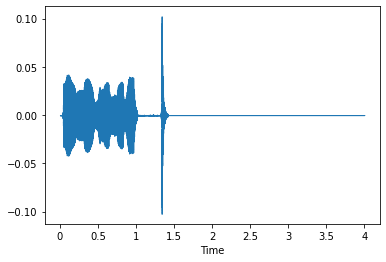

In [83]:
#Plotting an audio file to decide which window dimension may be suitable
idx = 4
y =  df_pd.audio_trim[4]
librosa.display.waveshow(y, sr=sr, x_axis='time');

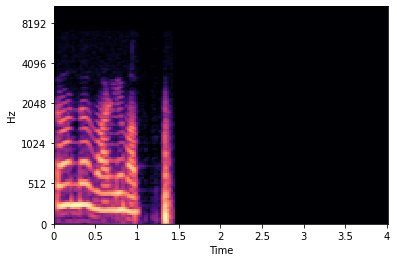

In [84]:
S1 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

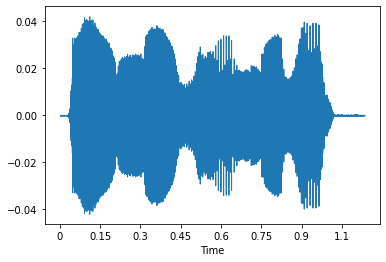

In [85]:
y =  df_pd.audio_trim[idx]
librosa.display.waveshow(y[:25000], sr=sr, x_axis='time');

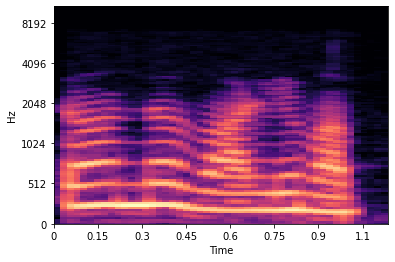

In [86]:
S1 = librosa.feature.melspectrogram(y=y[:25000], sr=sr, n_mels=128)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [87]:
len(y)/sr

4.0

In [88]:
4*sr

88200

In [89]:
0.2 *sr

4410.0

In [90]:
88200/4410

20.0

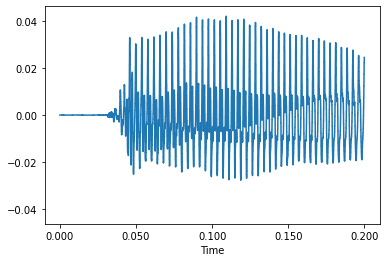

In [91]:
y =  df_pd.audio_trim[idx]
librosa.display.waveshow(y[:4410], sr=sr, x_axis='time');

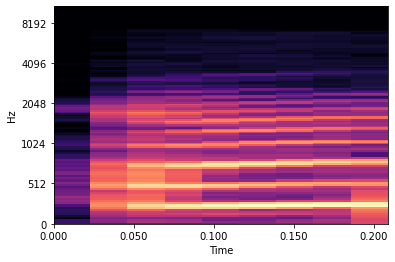

In [97]:
S1 = librosa.feature.melspectrogram(y=y[:4410], sr=sr, n_mels=128)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

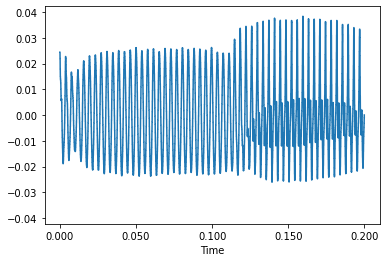

In [95]:
librosa.display.waveshow(y[4410:8820], sr=sr, x_axis='time');

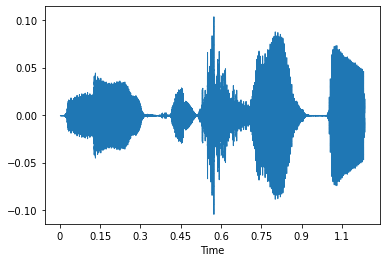

In [104]:
idx=40
y =  df_pd.audio_trim[idx]
librosa.display.waveshow(y[:25000], sr=sr, x_axis='time');

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


features = []
hop_length = 128
frame_rate = sr*2/hop_length

n_ffts = [512, 1024, 2048, 4096, 8192]
hops = [64, 128, 256, 512, 1024, 2048, 4096]

categorical_features = ["gender=male", 'ageRange=41-65', 'ageRange=65+']

svm = True

# for n_fft in n_ffts:
#     for hop in hops:
#         if hop < n_fft:
features = []
for i, audio in enumerate(df_pd.audio_reconstructed):
#n_fft = int(frame_rate*len(audio))
#For each trim audio extract MFCC (so we will get a matrix of n_mfcc components*nc, with nc variable)
    mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], 
                              sr=sr*2, 
                              n_mfcc=13,
                              lifter = 10, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mels = 40,
                            dct_type=2)
#    mfcc_features = sklearn.preprocessing.scale(mfcc_features, axis=1)
#   mel_features = librosa.feature.melspectrogram(y=df_pd.audio_trim[i], sr=sr)
#   spectogram = librosa.power_to_db(mel_features, ref=np.max)

#For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    mfcc_means = mfcc_features.mean(axis=1)
    mfcc_medians = np.median(mfcc_features, axis=1)
    mfcc_stds = mfcc_features.std(axis=1)
    mfcc_maxs = mfcc_features.max(axis=1)
    mfcc_mins = mfcc_features.min(axis=1)

    #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
    audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)
    #adjust spectogram size to get nice number of columns that are easy to divide3
    #spectogram= np.hstack((spectogram,tmp))

    #spectograms.append(spectogram)
    
new_df = pd.DataFrame(features)
if svm == True:
  scaled_numerical_df = scaler.fit_transform(new_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df)
else:
    scaled_numerical_df = pd.DataFrame(features)


X = pd.concat([df_pd[categorical_features], scaled_numerical_df], axis=1)
y = df_pd["label"]

if i == 0:
  print(X.shape, y.shape)

# new_df['gender=male'] = df_pd["gender=male"]
# new_df['ageRange=41-65'] = df_pd["ageRange=41-65"]
# new_df['ageRange=65+'] = df_pd["ageRange=65+"]
# new_df['label'] = df_pd["label"]

# y = new_df['label']
# X = new_df.drop(columns='label')
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# if svm == True: #standardize
#   X_train_scaled = scaler.fit_transform(X_train)
#   X_test_scaled = scaler.transform(X_test)

print("###########################################################")
print("DATASET SHAPE")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("")

# print(f"HYPERPARAMS: n_fft = {n_fft}, hop = {hop}")
# print("")

_, _, best_score = svm_classifier(X_train, y_train, 10, seed)
print("")
print(f"BEST RESULT: {best_score}")
print("")
            
            

In [ ]:
mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[1], sr=sr)
print(mfcc_features.shape)

medians = np.median(mfcc_features, axis=1)
print(medians.shape)

means = mfcc_features.mean(axis=0)
medians = np.median(mfcc_features, axis=1)
stds = mfcc_features.std(axis=1)
maxs = mfcc_features.max(axis=1)
mins = mfcc_features.min(axis=1)
# stds = mfcc_features.std(axis=1)
# print(len(means), len(stds))
# row = list(means)+list(stds)
# print((row))
# print("")
# print(means)
# print("")
# print(stds)


(20, 28)
(20,)


In [ ]:
seed = 42

In [ ]:
### RandomForest Classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[100], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results, best_score_RF



In [ ]:
### RandomForest Classifier ###
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svm_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_SVM= SVC(random_state =seed)

    parameters = {'kernel':  ['rbf'], 
                   "C" : [11, 12, 13, 14],
                  "gamma" : ['auto']
                  }

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_SVM = GridSearchCV(estimator=model_SVM,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_SVM.fit(input_x, input_y)
    best_parameters = grid_search_SVM.best_params_  
    best_score = grid_search_SVM.best_score_ 
    print(best_parameters)
    print(best_score)
    results = grid_search_SVM.cv_results_
    
    return best_parameters, results, best_score



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


features = []
hop_length = 128
frame_rate = sr*2/hop_length

n_ffts = [512, 1024, 2048, 4096, 8192]
hops = [64, 128, 256, 512, 1024, 2048, 4096]

categorical_features = ["gender=male", 'ageRange=41-65', 'ageRange=65+']

svm = True

# for n_fft in n_ffts:
#     for hop in hops:
#         if hop < n_fft:
features = []
for i, audio in enumerate(df_pd.audio_reconstructed):
#n_fft = int(frame_rate*len(audio))
#For each trim audio extract MFCC (so we will get a matrix of n_mfcc components*nc, with nc variable)
    mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], 
                              sr=sr*2, 
                              n_mfcc=13,
                              lifter = 10, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mels = 40,
                            dct_type=2)
#    mfcc_features = sklearn.preprocessing.scale(mfcc_features, axis=1)
#   mel_features = librosa.feature.melspectrogram(y=df_pd.audio_trim[i], sr=sr)
#   spectogram = librosa.power_to_db(mel_features, ref=np.max)

#For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    mfcc_means = mfcc_features.mean(axis=1)
    mfcc_medians = np.median(mfcc_features, axis=1)
    mfcc_stds = mfcc_features.std(axis=1)
    mfcc_maxs = mfcc_features.max(axis=1)
    mfcc_mins = mfcc_features.min(axis=1)

    #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
    audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)
    #adjust spectogram size to get nice number of columns that are easy to divide3
    #spectogram= np.hstack((spectogram,tmp))

    #spectograms.append(spectogram)
    
new_df = pd.DataFrame(features)
if svm == True:
  scaled_numerical_df = scaler.fit_transform(new_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df)
else:
    scaled_numerical_df = pd.DataFrame(features)


X = pd.concat([df_pd[categorical_features], scaled_numerical_df], axis=1)
y = df_pd["label"]

if i == 0:
  print(X.shape, y.shape)

# new_df['gender=male'] = df_pd["gender=male"]
# new_df['ageRange=41-65'] = df_pd["ageRange=41-65"]
# new_df['ageRange=65+'] = df_pd["ageRange=65+"]
# new_df['label'] = df_pd["label"]

# y = new_df['label']
# X = new_df.drop(columns='label')
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# if svm == True: #standardize
#   X_train_scaled = scaler.fit_transform(X_train)
#   X_test_scaled = scaler.transform(X_test)

print("###########################################################")
print("DATASET SHAPE")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("")

# print(f"HYPERPARAMS: n_fft = {n_fft}, hop = {hop}")
# print("")

_, _, best_score = svm_classifier(X_train, y_train, 10, seed)
print("")
print(f"BEST RESULT: {best_score}")
print("")
            
            

###########################################################
DATASET SHAPE
(7878, 68) (1970, 68) (7878,) (1970,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'C': 12, 'gamma': 'auto', 'kernel': 'rbf'}
0.6552402943775437

BEST RESULT: 0.6552402943775437



In [ ]:
  new_df = pd.DataFrame(features)

In [ ]:
#Test

# index = 1
# mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[index], sr=sr)
# print(mfcc_features.shape)

# medians = np.median(mfcc_features, axis=1)
# print(medians.shape)

# means = mfcc_features.mean(axis=1)
# medians = np.median(mfcc_features, axis=1)
# stds = mfcc_features.std(axis=1)
# maxs = mfcc_features.max(axis=1)
# mins = mfcc_features.min(axis=1)
# mins

In [ ]:
#Add one hot encoding features and label column
new_df['gender=male'] = df_pd["gender=male"]
new_df['ageRange=41-65'] = df_pd["ageRange=41-65"]
new_df['ageRange=65+'] = df_pd["ageRange=65+"]
new_df['label'] = df_pd["label"]

In [ ]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,gender=male,ageRange=41-65,ageRange=65+,label
0,-654.978149,266.147034,-232.756287,204.047974,-386.087677,70.316353,-104.309944,-15.423725,-60.210785,-5.208535,...,-118.631729,-104.649719,-31.237093,0.015917,-8.756983,-15.892126,0,0,0,5
1,-788.408508,339.816681,-174.225296,137.939224,-227.956833,29.518757,-128.914902,21.448252,-67.127380,-3.915097,...,-113.725571,-121.354858,-24.809935,2.680358,8.757540,17.897354,0,0,0,6
2,-939.727173,555.871826,-257.650970,-52.364635,-51.672264,-32.816715,-106.138161,55.906471,-58.916706,-17.894106,...,-62.581871,-121.498207,-34.133976,-3.045390,-24.359169,-13.379682,0,0,0,7
3,-508.933044,419.745728,-443.796692,125.313591,-225.768005,59.677464,-102.039719,-29.348854,-22.342733,-14.533762,...,-90.700951,-58.892715,-38.069736,1.805272,-3.159659,-10.925360,0,0,0,1
4,-957.366089,678.238403,-244.650711,-146.730103,64.905457,-83.696617,-81.330528,5.969497,-37.702721,-21.758728,...,-47.281780,-74.267036,-40.814743,-1.424215,-7.308774,-13.394814,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,-389.328949,537.848694,-318.830078,96.194000,-221.532883,75.032234,-37.723171,-55.868301,-17.517597,-2.130046,...,-143.091904,-66.653831,-16.152851,0.942129,-30.827900,-17.219553,1,0,0,3
9484,-373.620209,423.923492,-315.671143,80.269203,-320.812164,130.879639,-91.896729,-35.442120,-2.797575,1.394078,...,-163.965912,-56.331928,-19.432053,-9.365868,-13.883176,-30.704874,1,0,0,7
9485,-377.192047,486.606506,-390.254395,18.689823,-226.928131,119.542358,-54.385330,-33.894749,-11.903637,0.599520,...,-123.683510,-60.877983,-14.356465,-1.956916,-20.179590,-25.053640,1,0,0,7
9486,-289.317780,471.563354,-393.444153,73.781502,-346.154572,154.330353,-78.557877,-53.864761,-24.253027,-2.271663,...,-139.371735,-76.906059,-9.071911,-0.310656,-2.380613,-27.433468,1,0,0,7


In [ ]:
# indexes

In [ ]:
# name_file = r'/df.pickle'

# with open(path_working_directory+name_file, 'rb') as f:
#         df = pickle.load(f)
# df_tmp = pd.DataFrame({'audio':df[1], 'gender': df_development.gender, 'ageRange': df_development.ageRange, 'label':df[3]})
# #df_pd[9840:9845] ETICHETTATO COME FEMALE MA SECONDO ME E MALE
# pd.DataFrame(df_tmp).iloc[23:28]

In [ ]:
# df_pd.iloc[23:28]

In [ ]:
# df_tmp['audio'][26]

In [ ]:
# df_tmp['audio'][24] == df_pd['audio'][24]

### 4. Training and Validation

In [ ]:
y = new_df['label']
X = new_df.drop(columns='label')
seed = 42

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((7590, 68), (1898, 68), (7590,), (1898,))

In [ ]:
### RandomForest Classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[100], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results

best_params, RF_CV_results = randforest_classifier(X_train, y_train, 10, seed)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.5274044795783926


In [ ]:
rf = RandomForestClassifier(n_estimators=50,criterion='entropy', max_features="sqrt", random_state =seed)
rf.fit(X_train, y_train)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=50, random_state=42)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', 'gender=male', 'ageRange=41-65', 'ageRange=65+']
means: 0-12
medians: 13-25
stds: 26-38
max: 39-51
min: 52-64


Text(0, 0.5, 'Mean decrease in impurity')

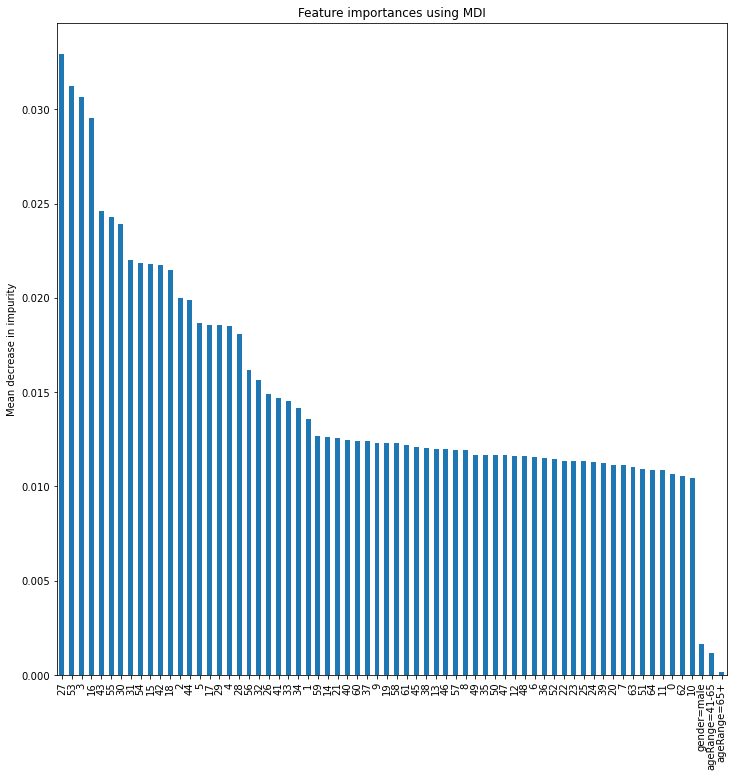

In [ ]:
feature_names = [f"{f}" for f in X_train.columns]
print(feature_names)
importances=rf.feature_importances_
forest_importances=  pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("means: 0-12")
print("medians: 13-25")
print("stds: 26-38")
print("max: 39-51")
print("min: 52-64")
plt.figure(figsize=(12,12))
forest_importances.plot.bar()
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")


100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=1024): 0.5019027470507421

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=2048, hop_length=256): 0.5107861570314567

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=2048, hop_length=128) = 0.5144707138203936

100 alberi   mfcc_features = librosa.feature.mfcc(y=df_pd.audio_emph[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128) = 0.5152318126406905

100 alberi mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128): 0.520815407736118

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.523992189062107

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.5242471249169564

100 alberi,   mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.5308446584407794

200 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=128, n_mels = 90): 0.538330839337199

100, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=128, n_mels = 90, dct_type=1) = 0.5279249092163907

100, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i],  sr=sr*2, n_mfcc=13,lifter = 10,  n_fft=4096, hop_length=128, n_mels = 90, dct_type=3): 0.5046902714800793

**BEST**: 100 alberi,  tagliando trim audios > 1 sec mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=64, n_mels = 90, dct_type=2): **0.5398856887280141**

100 alberi,  tagliando trim audios > 2 sec mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=64, n_mels = 90, dct_type=2): **0.5274044795783926**








In [ ]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,gender=male,ageRange=41-65,ageRange=65+,label
0,-654.978149,266.147034,-232.756287,204.047974,-386.087677,70.316353,-104.309944,-15.423725,-60.210785,-5.208535,...,-118.631729,-104.649719,-31.237093,0.015917,-8.756983,-15.892126,0,0,0,5
1,-788.408508,339.816681,-174.225296,137.939224,-227.956833,29.518757,-128.914902,21.448252,-67.127380,-3.915097,...,-113.725571,-121.354858,-24.809935,2.680358,8.757540,17.897354,0,0,0,6
2,-939.727173,555.871826,-257.650970,-52.364635,-51.672264,-32.816715,-106.138161,55.906471,-58.916706,-17.894106,...,-62.581871,-121.498207,-34.133976,-3.045390,-24.359169,-13.379682,0,0,0,7
3,-508.933044,419.745728,-443.796692,125.313591,-225.768005,59.677464,-102.039719,-29.348854,-22.342733,-14.533762,...,-90.700951,-58.892715,-38.069736,1.805272,-3.159659,-10.925360,0,0,0,1
4,-957.366089,678.238403,-244.650711,-146.730103,64.905457,-83.696617,-81.330528,5.969497,-37.702721,-21.758728,...,-47.281780,-74.267036,-40.814743,-1.424215,-7.308774,-13.394814,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,-389.328949,537.848694,-318.830078,96.194000,-221.532883,75.032234,-37.723171,-55.868301,-17.517597,-2.130046,...,-143.091904,-66.653831,-16.152851,0.942129,-30.827900,-17.219553,1,0,0,3
9484,-373.620209,423.923492,-315.671143,80.269203,-320.812164,130.879639,-91.896729,-35.442120,-2.797575,1.394078,...,-163.965912,-56.331928,-19.432053,-9.365868,-13.883176,-30.704874,1,0,0,7
9485,-377.192047,486.606506,-390.254395,18.689823,-226.928131,119.542358,-54.385330,-33.894749,-11.903637,0.599520,...,-123.683510,-60.877983,-14.356465,-1.956916,-20.179590,-25.053640,1,0,0,7
9486,-289.317780,471.563354,-393.444153,73.781502,-346.154572,154.330353,-78.557877,-53.864761,-24.253027,-2.271663,...,-139.371735,-76.906059,-9.071911,-0.310656,-2.380613,-27.433468,1,0,0,7


In [ ]:
new_df['ageRange=41-65']

0       0
1       0
2       0
3       0
4       0
       ..
9483    0
9484    0
9485    0
9486    0
9487    0
Name: ageRange=41-65, Length: 9488, dtype: uint8

In [ ]:
# df_pd['label'][7167]

We noticed that some audios (ex. index = 7167) are kept because there noise (no silence) and trim is not able to erase it away, so now we apply noise reduction.

Let's listent the audio.

In [ ]:
# # 7167 : rumore finale che non toglie
# index = 7167
# s1 = df_pd['audio'][index]
# ipd.Audio(df_pd['audio'][index], rate=22050)
# plt.figure()
# plt.plot(s1)

In [ ]:
# # Original audio
# ipd.Audio(s1, rate=22050)

In [ ]:
# # Trim audio
# s1_trim = librosa.effects.trim(s1, top_db=20)[0]
# ipd.Audio(s1_trim, rate=22050)

It says "decrease the volume" (label 3), we now take another audio saying the same without noise to compare them.

In [ ]:
# # Retrieve all the rows having label = 3 and then the corresponding indexes
# df_label3 = df_pd[df_pd['label']==3]
# indexes_label3 = list(df_label3.index)
# indexes_label3

In [ ]:
# index = 691 #this audio seems clearer
# s2 = df_pd['audio'][index]

# ipd.Audio(s2, rate=22050)
# plt.figure()
# plt.plot(s2)

In [ ]:
# ipd.Audio(s2, rate=22050)

In [ ]:
# s2_trim = librosa.effects.trim(s2, top_db=20)[0]
# ipd.Audio(s2_trim, rate=22050)

Let's plot the spectograms

In [ ]:
# S1 = librosa.feature.melspectrogram(y=s1, sr=sr, n_mels=128)
# D1 = librosa.power_to_db(S1, ref=np.max)
# librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [ ]:
# S2 = librosa.feature.melspectrogram(y=s2, sr=sr, n_mels=128)
# D2 = librosa.power_to_db(S2, ref=np.max)
# librosa.display.specshow(D2, x_axis='time', y_axis='mel');

In [ ]:
# from scipy import signal
# import random


# def f_high(y,sr):
#     b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
#     yf = signal.lfilter(b,a,y)
#     return yf

In [ ]:
# yf1 = f_high(s1, sr)
# yf2 = f_high(s2, sr)

In [ ]:
# librosa.display.waveshow(s1,sr=sr, x_axis='time');
# librosa.display.waveshow(yf1,sr=sr, x_axis='time');

In [ ]:
# S1_new = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=128)
# D1 = librosa.power_to_db(S1_new, ref=np.max)
# librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [ ]:
# # Dp1 = librosa.pcen(S1 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)
# # Dp2 = librosa.pcen(S2 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)

# Dp1 = librosa.pcen(S1 * (2**31), sr=sr)
# Dp2 = librosa.pcen(S2 * (2**31), sr=sr)

In [ ]:
# librosa.display.specshow(Dp1, x_axis='time', y_axis='mel');

In [ ]:
# librosa.display.specshow(Dp2, x_axis='time', y_axis='mel');

In [ ]:
# yp1 = librosa.feature.inverse.mel_to_audio(Dp1)
# yp2 = librosa.feature.inverse.mel_to_audio(Dp2)

In [ ]:
# librosa.display.waveshow(yp1,sr=sr, x_axis='time');
# librosa.display.waveshow(s1,sr=sr, x_axis='time');

In [ ]:
# librosa.display.waveshow(yp2,sr=sr, x_axis='time');
# librosa.display.waveshow(s2,sr=sr, x_axis='time');

In [ ]:
# ipd.Audio(yp1, rate=22050)


In [ ]:
# ipd.Audio(yp2, rate=22050)

In [ ]:
# import time
# from datetime import timedelta as td


# def _stft(y, n_fft, hop_length, win_length):
#     return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


# def _istft(y, hop_length, win_length):
#     return librosa.istft(y, hop_length, win_length)


# def _amp_to_db(x):
#     return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


# def _db_to_amp(x,):
#     return librosa.core.db_to_amplitude(x, ref=1.0)


# def plot_spectrogram(signal, title):
#     fig, ax = plt.subplots(figsize=(20, 4))
#     cax = ax.matshow(
#         signal,
#         origin="lower",
#         aspect="auto",
#         cmap=plt.cm.seismic,
#         vmin=-1 * np.max(np.abs(signal)),
#         vmax=np.max(np.abs(signal)),
#     )
#     fig.colorbar(cax)
#     ax.set_title(title)
#     plt.tight_layout()
#     plt.show()


# def plot_statistics_and_filter(
#     mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
# ):
#     fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
#     plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
#     plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
#     plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
#     ax[0].set_title("Threshold for mask")
#     ax[0].legend()
#     cax = ax[1].matshow(smoothing_filter, origin="lower")
#     fig.colorbar(cax)
#     ax[1].set_title("Filter for smoothing Mask")
#     plt.show()

# def removeNoise(
#     audio_clip,
#     noise_clip,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=1.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False,
# ):
#     """Remove noise from audio based upon a clip containing only noise

#     Args:
#         audio_clip (array): The first parameter.
#         noise_clip (array): The second parameter.
#         n_grad_freq (int): how many frequency channels to smooth over with the mask.
#         n_grad_time (int): how many time channels to smooth over with the mask.
#         n_fft (int): number audio of frames between STFT columns.
#         win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
#         hop_length (int):number audio of frames between STFT columns.
#         n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
#         prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
#         visual (bool): Whether to plot the steps of the algorithm

#     Returns:
#         array: The recovered signal with noise subtracted

#     """
#     if verbose:
#         start = time.time()
#     # STFT over noise
#     noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
#     noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
#     # Calculate statistics over noise
#     mean_freq_noise = np.mean(noise_stft_db, axis=1)
#     std_freq_noise = np.std(noise_stft_db, axis=1)
#     noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
#     if verbose:
#         print("STFT on noise:", td(seconds=time.time() - start))
#         start = time.time()
#     # STFT over signal
#     if verbose:
#         start = time.time()
#     sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
#     sig_stft_db = _amp_to_db(np.abs(sig_stft))
#     if verbose:
#         print("STFT on signal:", td(seconds=time.time() - start))
#         start = time.time()
#     # Calculate value to mask dB to
#     mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
#     #print(noise_thresh, mask_gain_dB)
#     # Create a smoothing filter for the mask in time and frequency
#     smoothing_filter = np.outer(
#         np.concatenate(
#             [
#                 np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
#                 np.linspace(1, 0, n_grad_freq + 2),
#             ]
#         )[1:-1],
#         np.concatenate(
#             [
#                 np.linspace(0, 1, n_grad_time + 1, endpoint=False),
#                 np.linspace(1, 0, n_grad_time + 2),
#             ]
#         )[1:-1],
#     )
#     smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
#     # calculate the threshold for each frequency/time bin
#     db_thresh = np.repeat(
#         np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
#         np.shape(sig_stft_db)[1],
#         axis=0,
#     ).T
#     # mask if the signal is above the threshold
#     sig_mask = sig_stft_db < db_thresh
#     if verbose:
#         print("Masking:", td(seconds=time.time() - start))
#         start = time.time()
#     # convolve the mask with a smoothing filter
#     sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
#     sig_mask = sig_mask * prop_decrease
#     if verbose:
#         print("Mask convolution:", td(seconds=time.time() - start))
#         start = time.time()
#     # mask the signal
#     sig_stft_db_masked = (
#         sig_stft_db * (1 - sig_mask)
#         + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
#     )  # mask real
#     sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
#     sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
#         1j * sig_imag_masked
#     )
#     if verbose:
#         print("Mask application:", td(seconds=time.time() - start))
#         start = time.time()
#     # recover the signal
#     recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
#     recovered_spec = _amp_to_db(
#         np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
#     )
#     if verbose:
#         print("Signal recovery:", td(seconds=time.time() - start))
#     if visual:
#         plot_spectrogram(noise_stft_db, title="Noise")
#     if visual:
#         plot_statistics_and_filter(
#             mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
#         )
#     if visual:
#         plot_spectrogram(sig_stft_db, title="Signal")
#     if visual:
#         plot_spectrogram(sig_mask, title="Mask applied")
#     if visual:
#         plot_spectrogram(sig_stft_db_masked, title="Masked signal")
#     if visual:
#         plot_spectrogram(recovered_spec, title="Recovered spectrogram")
#     return recovered_signal

In [ ]:
# import scipy
# noise1 = s1[5*sr:6*sr]
# yg1 = removeNoise(audio_clip=s1, noise_clip=noise1,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=1.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False)
# noise2 = s2[0:1*sr]
# yg2 = removeNoise(audio_clip=s2, noise_clip=noise2,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=2.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False)

In [ ]:
# plt.figure(figsize=(12,12))
# librosa.display.waveshow(s1,sr=sr, x_axis='time');
# librosa.display.waveshow(yg1,sr=sr, x_axis='time');

In [ ]:
# librosa.display.waveshow(s2,sr=sr, x_axis='time');
# librosa.display.waveshow(yg2,sr=sr, x_axis='time');

In [ ]:
# ipd.Audio(s1, rate=22050)

In [ ]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
#  Decomment if you are interested in retrieve indexes of audio within a specific range 
    if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
        indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
#print(length_audios_seconds.value_counts())
# plt.figure(figsize=(12,12))
# plt.title("Lenght of audios distribution (seconds)")
# length_audios_seconds.hist()
#print(length_audios_seconds)


In [ ]:
indexes

[3079,
 3179,
 3799,
 3807,
 3839,
 4073,
 4802,
 7123,
 7684,
 8140,
 8141,
 8228,
 8229,
 8230,
 8528]

In [ ]:
# s = df_pd['audio'][0][librosa.effects.split(df_pd['audio'][0])[1][0]:librosa.effects.split(df_pd['audio'][1])[0][-1]]
# df_pd['audio'][0][librosa.effects.split(df_pd['audio'][0], top_db=30)]#[1][0]:librosa.effects.split(df_pd['audio'][1])[0][-1]]
# librosa.effects.split(df_pd['audio'][0])
# ipd.Audio(s, rate=22050)

In [ ]:
idx = 4073
ipd.Audio(df_pd['audio'][idx], rate=22050)

In [ ]:
s = librosa.effects.split(df_pd['audio'][idx])[0]
non_silence_parts = librosa.effects.split(df_pd['audio'][idx], top_db=40)
print(non_silence_parts, non_silence_parts.shape)

audio_reconstructed = []
for part in non_silence_parts:
    audio_reconstructed.append(df_pd['audio'][idx][part[0]:part[-1]])
print(len(audio_reconstructed))
#     return df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[0][0]:librosa.effects.split(df_pd['audio'][3799])[0][-1]]

new_audio_reconstructed = np.hstack(audio_reconstructed)
#s1 = df_pd['audio'][idx][non_silence_parts[1][0]:non_silence_parts[1][-1]]
# s2 = df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[1][0]:librosa.effects.split(df_pd['audio'][3799])[1][-1]]

ipd.Audio(new_audio_reconstructed, rate=22050)
#ipd.Audio(s2, rate=22050)
#ipd.Audio(df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799][0]]), 22050)

[[ 9728 34304]] (1, 2)
1


In [ ]:
# def remove_silence (signal):
#     return signal[librosa.effects.split(signal)[0][0]:librosa.effects.split(signal)[0][-1]]
# signal_without_silence = remove_silence(df_pd['audio'][3799])

# ipd.Audio(signal_without_silence, rate=22050)